### <font color = aqua>Notice

In [45]:
# Conv [64, 3, 2] means [Output Channels = 64, Kernel Size = 3, Stride = 2]

### <font color = aqua>YOLOv9 Architecture

<img src="yolov9_Architecture.png" width="1000" height="1000">

### <font color = aqua>Import and Define

In [46]:
import torch
import torch.nn as nn
import ast
import contextlib
import json
import math
import platform
import warnings
import zipfile
from collections import OrderedDict, namedtuple
from copy import copy
from pathlib import Path
from urllib.parse import urlparse

from typing import Optional

import cv2
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
from IPython.display import display
from PIL import Image
from torch.cuda import amp

# from utils import TryExcept
# from utils.dataloaders import exif_transpose, letterbox
# from utils.general import (LOGGER, ROOT, Profile, check_requirements, check_suffix, check_version, colorstr,
#                            increment_path, is_notebook, make_divisible, non_max_suppression, scale_boxes,
#                            xywh2xyxy, xyxy2xywh, yaml_load)
# from utils.plots import Annotator, colors, save_one_box
# from utils.torch_utils import copy_attr, smart_inference_mode


def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p


class Conv(nn.Module):
    # Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))


class AConv(nn.Module):
    def __init__(self, c1, c2):  # ch_in, ch_out, shortcut, kernels, groups, expand
        super().__init__()
        self.cv1 = Conv(c1, c2, 3, 2, 1)

    def forward(self, x):
        x = torch.nn.functional.avg_pool2d(x, 2, 1, 0, False, True)
        return self.cv1(x)


class ADown(nn.Module):
    def __init__(self, c1, c2):  # ch_in, ch_out, shortcut, kernels, groups, expand
        super().__init__()
        self.c = c2 // 2
        self.cv1 = Conv(c1 // 2, self.c, 3, 2, 1)
        self.cv2 = Conv(c1 // 2, self.c, 1, 1, 0)

    def forward(self, x):
        x = torch.nn.functional.avg_pool2d(x, 2, 1, 0, False, True)
        x1,x2 = x.chunk(2, 1)
        x1 = self.cv1(x1)
        x2 = torch.nn.functional.max_pool2d(x2, 3, 2, 1)
        x2 = self.cv2(x2)
        return torch.cat((x1, x2), 1)


class RepConvN(nn.Module):
    """RepConv is a basic rep-style block, including training and deploy status
    This code is based on https://github.com/DingXiaoH/RepVGG/blob/main/repvgg.py
    """
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=3, s=1, p=1, g=1, d=1, act=True, bn=False, deploy=False):
        super().__init__()
        assert k == 3 and p == 1
        self.g = g
        self.c1 = c1
        self.c2 = c2
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

        self.bn = None
        self.conv1 = Conv(c1, c2, k, s, p=p, g=g, act=False)
        self.conv2 = Conv(c1, c2, 1, s, p=(p - k // 2), g=g, act=False)

    def forward_fuse(self, x):
        """Forward process"""
        return self.act(self.conv(x))

    def forward(self, x):
        """Forward process"""
        id_out = 0 if self.bn is None else self.bn(x)
        return self.act(self.conv1(x) + self.conv2(x) + id_out)

    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.conv1)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.conv2)
        kernelid, biasid = self._fuse_bn_tensor(self.bn)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _avg_to_3x3_tensor(self, avgp):
        channels = self.c1
        groups = self.g
        kernel_size = avgp.kernel_size
        input_dim = channels // groups
        k = torch.zeros((channels, input_dim, kernel_size, kernel_size))
        k[np.arange(channels), np.tile(np.arange(input_dim), groups), :, :] = 1.0 / kernel_size ** 2
        return k

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1, 1, 1, 1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, Conv):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        elif isinstance(branch, nn.BatchNorm2d):
            if not hasattr(self, 'id_tensor'):
                input_dim = self.c1 // self.g
                kernel_value = np.zeros((self.c1, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.c1):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def fuse_convs(self):
        if hasattr(self, 'conv'):
            return
        kernel, bias = self.get_equivalent_kernel_bias()
        self.conv = nn.Conv2d(in_channels=self.conv1.conv.in_channels,
                              out_channels=self.conv1.conv.out_channels,
                              kernel_size=self.conv1.conv.kernel_size,
                              stride=self.conv1.conv.stride,
                              padding=self.conv1.conv.padding,
                              dilation=self.conv1.conv.dilation,
                              groups=self.conv1.conv.groups,
                              bias=True).requires_grad_(False)
        self.conv.weight.data = kernel
        self.conv.bias.data = bias
        for para in self.parameters():
            para.detach_()
        self.__delattr__('conv1')
        self.__delattr__('conv2')
        if hasattr(self, 'nm'):
            self.__delattr__('nm')
        if hasattr(self, 'bn'):
            self.__delattr__('bn')
        if hasattr(self, 'id_tensor'):
            self.__delattr__('id_tensor')


class SP(nn.Module):
    def __init__(self, k=3, s=1):
        super(SP, self).__init__()
        self.m = nn.MaxPool2d(kernel_size=k, stride=s, padding=k // 2)

    def forward(self, x):
        return self.m(x)


class MP(nn.Module):
    # Max pooling
    def __init__(self, k=2):
        super(MP, self).__init__()
        self.m = nn.MaxPool2d(kernel_size=k, stride=k)

    def forward(self, x):
        return self.m(x)


class ConvTranspose(nn.Module):
    # Convolution transpose 2d layer
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=2, s=2, p=0, bn=True, act=True):
        super().__init__()
        self.conv_transpose = nn.ConvTranspose2d(c1, c2, k, s, p, bias=not bn)
        self.bn = nn.BatchNorm2d(c2) if bn else nn.Identity()
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv_transpose(x)))


class DWConv(Conv):
    # Depth-wise convolution
    def __init__(self, c1, c2, k=1, s=1, d=1, act=True):  # ch_in, ch_out, kernel, stride, dilation, activation
        super().__init__(c1, c2, k, s, g=math.gcd(c1, c2), d=d, act=act)


class DWConvTranspose2d(nn.ConvTranspose2d):
    # Depth-wise transpose convolution
    def __init__(self, c1, c2, k=1, s=1, p1=0, p2=0):  # ch_in, ch_out, kernel, stride, padding, padding_out
        super().__init__(c1, c2, k, s, p1, p2, groups=math.gcd(c1, c2))


class DFL(nn.Module):
    # DFL module
    def __init__(self, c1=17):
        super().__init__()
        self.conv = nn.Conv2d(c1, 1, 1, bias=False).requires_grad_(False)
        self.conv.weight.data[:] = nn.Parameter(torch.arange(c1, dtype=torch.float).view(1, c1, 1, 1)) # / 120.0
        self.c1 = c1
        # self.bn = nn.BatchNorm2d(4)

    def forward(self, x):
        b, c, a = x.shape  # batch, channels, anchors
        return self.conv(x.view(b, 4, self.c1, a).transpose(2, 1).softmax(1)).view(b, 4, a)
        # return self.conv(x.view(b, self.c1, 4, a).softmax(1)).view(b, 4, a)


class BottleneckBase(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, k=(1, 3), e=0.5):  # ch_in, ch_out, shortcut, kernels, groups, expand
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class RBottleneckBase(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, k=(3, 1), e=0.5):  # ch_in, ch_out, shortcut, kernels, groups, expand
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class RepNRBottleneckBase(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, k=(3, 1), e=0.5):  # ch_in, ch_out, shortcut, kernels, groups, expand
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = RepConvN(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class Bottleneck(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, k=(3, 3), e=0.5):  # ch_in, ch_out, shortcut, kernels, groups, expand
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class RepNBottleneck(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, k=(3, 3), e=0.5):  # ch_in, ch_out, shortcut, kernels, groups, expand
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = RepConvN(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class Res(nn.Module):
    # ResNet bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, shortcut, groups, expansion
        super(Res, self).__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_, c_, 3, 1, g=g)
        self.cv3 = Conv(c_, c2, 1, 1)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv3(self.cv2(self.cv1(x))) if self.add else self.cv3(self.cv2(self.cv1(x)))


class RepNRes(nn.Module):
    # ResNet bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, shortcut, groups, expansion
        super(RepNRes, self).__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = RepConvN(c_, c_, 3, 1, g=g)
        self.cv3 = Conv(c_, c2, 1, 1)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv3(self.cv2(self.cv1(x))) if self.add else self.cv3(self.cv2(self.cv1(x)))


class BottleneckCSP(nn.Module):
    # CSP Bottleneck https://github.com/WongKinYiu/CrossStagePartialNetworks
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = nn.Conv2d(c1, c_, 1, 1, bias=False)
        self.cv3 = nn.Conv2d(c_, c_, 1, 1, bias=False)
        self.cv4 = Conv(2 * c_, c2, 1, 1)
        self.bn = nn.BatchNorm2d(2 * c_)  # applied to cat(cv2, cv3)
        self.act = nn.SiLU()
        self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        y1 = self.cv3(self.m(self.cv1(x)))
        y2 = self.cv2(x)
        return self.cv4(self.act(self.bn(torch.cat((y1, y2), 1))))


class CSP(nn.Module):
    # CSP Bottleneck with 3 convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


class RepNCSP(nn.Module):
    # CSP Bottleneck with 3 convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(*(RepNBottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


class CSPBase(nn.Module):
    # CSP Bottleneck with 3 convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(*(BottleneckBase(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


class SPP(nn.Module):
    # Spatial Pyramid Pooling (SPP) layer https://arxiv.org/abs/1406.4729
    def __init__(self, c1, c2, k=(5, 9, 13)):
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * (len(k) + 1), c2, 1, 1)
        self.m = nn.ModuleList([nn.MaxPool2d(kernel_size=x, stride=1, padding=x // 2) for x in k])

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress torch 1.9.0 max_pool2d() warning
            return self.cv2(torch.cat([x] + [m(x) for m in self.m], 1))


class ASPP(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        kernel_sizes = [1, 3, 3, 1]
        dilations = [1, 3, 6, 1]
        paddings = [0, 3, 6, 0]
        self.aspp = torch.nn.ModuleList()
        for aspp_idx in range(len(kernel_sizes)):
            conv = torch.nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_sizes[aspp_idx],
                stride=1,
                dilation=dilations[aspp_idx],
                padding=paddings[aspp_idx],
                bias=True)
            self.aspp.append(conv)
        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.aspp_num = len(kernel_sizes)
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.fill_(0)

    def forward(self, x):
        avg_x = self.gap(x)
        out = []
        for aspp_idx in range(self.aspp_num):
            inp = avg_x if (aspp_idx == self.aspp_num - 1) else x
            out.append(F.relu_(self.aspp[aspp_idx](inp)))
        out[-1] = out[-1].expand_as(out[-2])
        out = torch.cat(out, dim=1)
        return out


class SPPCSPC(nn.Module):
    # CSP SPP https://github.com/WongKinYiu/CrossStagePartialNetworks
    def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5, k=(5, 9, 13)):
        super(SPPCSPC, self).__init__()
        c_ = int(2 * c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(c_, c_, 3, 1)
        self.cv4 = Conv(c_, c_, 1, 1)
        self.m = nn.ModuleList([nn.MaxPool2d(kernel_size=x, stride=1, padding=x // 2) for x in k])
        self.cv5 = Conv(4 * c_, c_, 1, 1)
        self.cv6 = Conv(c_, c_, 3, 1)
        self.cv7 = Conv(2 * c_, c2, 1, 1)

    def forward(self, x):
        x1 = self.cv4(self.cv3(self.cv1(x)))
        y1 = self.cv6(self.cv5(torch.cat([x1] + [m(x1) for m in self.m], 1)))
        y2 = self.cv2(x)
        return self.cv7(torch.cat((y1, y2), dim=1))


class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)
        # self.m = SoftPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress torch 1.9.0 max_pool2d() warning
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))


import torch.nn.functional as F
from torch.nn.modules.utils import _pair


class ReOrg(nn.Module):
    # yolo
    def __init__(self):
        super(ReOrg, self).__init__()

    def forward(self, x):  # x(b,c,w,h) -> y(b,4c,w/2,h/2)
        return torch.cat([x[..., ::2, ::2], x[..., 1::2, ::2], x[..., ::2, 1::2], x[..., 1::2, 1::2]], 1)


class Contract(nn.Module):
    # Contract width-height into channels, i.e. x(1,64,80,80) to x(1,256,40,40)
    def __init__(self, gain=2):
        super().__init__()
        self.gain = gain

    def forward(self, x):
        b, c, h, w = x.size()  # assert (h / s == 0) and (W / s == 0), 'Indivisible gain'
        s = self.gain
        x = x.view(b, c, h // s, s, w // s, s)  # x(1,64,40,2,40,2)
        x = x.permute(0, 3, 5, 1, 2, 4).contiguous()  # x(1,2,2,64,40,40)
        return x.view(b, c * s * s, h // s, w // s)  # x(1,256,40,40)


class Expand(nn.Module):
    # Expand channels into width-height, i.e. x(1,64,80,80) to x(1,16,160,160)
    def __init__(self, gain=2):
        super().__init__()
        self.gain = gain

    def forward(self, x):
        b, c, h, w = x.size()  # assert C / s ** 2 == 0, 'Indivisible gain'
        s = self.gain
        x = x.view(b, s, s, c // s ** 2, h, w)  # x(1,2,2,16,80,80)
        x = x.permute(0, 3, 4, 1, 5, 2).contiguous()  # x(1,16,80,2,80,2)
        return x.view(b, c // s ** 2, h * s, w * s)  # x(1,16,160,160)


class Concat(nn.Module):
    # Concatenate a list of tensors along dimension
    def __init__(self, dimension=1):
        super().__init__()
        self.d = dimension

    def forward(self, x):
        return torch.cat(x, self.d)


class Shortcut(nn.Module):
    def __init__(self, dimension=0):
        super(Shortcut, self).__init__()
        self.d = dimension

    def forward(self, x):
        return x[0]+x[1]


class Silence(nn.Module):
    def __init__(self):
        super(Silence, self).__init__()
    def forward(self, x):
        return x


##### GELAN #####

class SPPELAN(nn.Module):
    # spp-elan
    def __init__(self, c1, c2, c3):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        self.c = c3
        self.cv1 = Conv(c1, c3, 1, 1)
        self.cv2 = SP(5)
        self.cv3 = SP(5)
        self.cv4 = SP(5)
        self.cv5 = Conv(4*c3, c2, 1, 1)

    def forward(self, x):
        y = [self.cv1(x)]
        y.extend(m(y[-1]) for m in [self.cv2, self.cv3, self.cv4])
        return self.cv5(torch.cat(y, 1))


class ELAN1(nn.Module):

    def __init__(self, c1, c2, c3, c4):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        self.c = c3//2
        self.cv1 = Conv(c1, c3, 1, 1)
        self.cv2 = Conv(c3//2, c4, 3, 1)
        self.cv3 = Conv(c4, c4, 3, 1)
        self.cv4 = Conv(c3+(2*c4), c2, 1, 1)

    def forward(self, x):
        y = list(self.cv1(x).chunk(2, 1))
        y.extend(m(y[-1]) for m in [self.cv2, self.cv3])
        return self.cv4(torch.cat(y, 1))

    def forward_split(self, x):
        y = list(self.cv1(x).split((self.c, self.c), 1))
        y.extend(m(y[-1]) for m in [self.cv2, self.cv3])
        return self.cv4(torch.cat(y, 1))


class RepNCSPELAN4(nn.Module):
    # csp-elan
    def __init__(self, c1, c2, c3, c4, c5=1):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        self.c = c3//2
        self.cv1 = Conv(c1, c3, 1, 1)
        self.cv2 = nn.Sequential(RepNCSP(c3//2, c4, c5), Conv(c4, c4, 3, 1))
        self.cv3 = nn.Sequential(RepNCSP(c4, c4, c5), Conv(c4, c4, 3, 1))
        self.cv4 = Conv(c3+(2*c4), c2, 1, 1)

    def forward(self, x):
        y = list(self.cv1(x).chunk(2, 1))
        y.extend((m(y[-1])) for m in [self.cv2, self.cv3])
        return self.cv4(torch.cat(y, 1))

    def forward_split(self, x):
        y = list(self.cv1(x).split((self.c, self.c), 1))
        y.extend(m(y[-1]) for m in [self.cv2, self.cv3])
        return self.cv4(torch.cat(y, 1))

#################


##### YOLOR #####

class ImplicitA(nn.Module):
    def __init__(self, channel):
        super(ImplicitA, self).__init__()
        self.channel = channel
        self.implicit = nn.Parameter(torch.zeros(1, channel, 1, 1))
        nn.init.normal_(self.implicit, std=.02)

    def forward(self, x):
        return self.implicit + x


class ImplicitM(nn.Module):
    def __init__(self, channel):
        super(ImplicitM, self).__init__()
        self.channel = channel
        self.implicit = nn.Parameter(torch.ones(1, channel, 1, 1))
        nn.init.normal_(self.implicit, mean=1., std=.02)

    def forward(self, x):
        return self.implicit * x

#################


##### CBNet #####

class CBLinear(nn.Module):
    def __init__(self, c1, c2s, k=1, s=1, p=None, g=1):  # ch_in, ch_outs, kernel, stride, padding, groups
        super(CBLinear, self).__init__()
        self.c2s = c2s
        self.conv = nn.Conv2d(c1, sum(c2s), k, s, autopad(k, p), groups=g, bias=True)

    def forward(self, x):
        outs = self.conv(x).split(self.c2s, dim=1)
        return outs

class CBFuse(nn.Module):
    def __init__(self, idx):
        super(CBFuse, self).__init__()
        self.idx = idx

    def forward(self, xs):
        target_size = xs[-1].shape[2:]
        res = [F.interpolate(x[self.idx[i]], size=target_size, mode='nearest') for i, x in enumerate(xs[:-1])]
        out = torch.sum(torch.stack(res + xs[-1:]), dim=0)
        return out

#################

### <font color = aqua>Simulated Data

In [47]:
# input:[batch_size, channels, height, width]
batch_size = 1
channels = 3
height, width = 640, 640
# data = torch.arange(1, 1 + (batch_size * channels * height * width), dtype=torch.float32).reshape(batch_size, channels, height, width)
data = cv2.imread('/content/drive/MyDrive/yolov9-architecture.png')
data = cv2.resize(data,(64, 64))
data = torch.tensor(data, dtype=torch.float32)
data = data.permute(2, 0, 1)
data = data / 255.0

# 添加 batch 维度，变成 [1, 3, 64, 64]
data = data.unsqueeze(0)
print(data.shape)
# print(data)


batch_size = data.shape[0]
channels = data.shape[1]
height = data.shape[2]
width = data.shape[3]
import numpy as np
import matplotlib.pyplot as plt
import torch
import matplotlib.pyplot as plt
import numpy as np

def show_images(image_tensor, images_per_row=10):
    # Squeeze the batch dimension (1) if present, resulting in [C, H, W]
    image_tensor = image_tensor.squeeze(0)

    # Check if we have a batch of images (i.e., more than one channel)
    num_images = image_tensor.shape[0]  # Number of images (or channels)

    # Handle if there are multiple channels (e.g., RGB, or more)
    # If it's a multi-channel image, we'll need to separate or extract them
    if image_tensor.ndimension() == 3:
        # If we have a 3D tensor like [num_images, height, width], assume grayscale
        images = image_tensor
    else:
        # If we have a 4D tensor, e.g., [batch_size, num_images, height, width], squeeze first
        images = image_tensor

    # Calculate grid size
    num_rows = (num_images + images_per_row - 1) // images_per_row  # Ceiling division

    # Create a figure to display images
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))
    axes = axes.flatten()  # Flatten the 2D grid of axes to easily index them

    # Display each image in the grid
    for i in range(num_images):
        ax = axes[i]
        img = images[i].cpu().numpy()

        if img.ndim == 2:  # Grayscale
            ax.imshow(img, cmap='gray')
        elif img.ndim == 3 and img.shape[0] == 3:  # RGB
            img = img.transpose(1, 2, 0)  # Convert to HWC
            ax.imshow(img)

        ax.axis('off')  # Hide axis

    # Hide any remaining unused axes
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    # Adjust layout and show the grid
    plt.tight_layout()
    plt.show()

# Example usage:
# Assume image_tensor is of shape [1, 20, 640, 640] (which can be more than 20 images/channels)


torch.Size([1, 3, 64, 64])


### <font color = aqua>Silence

torch.Size([1, 3, 64, 64])


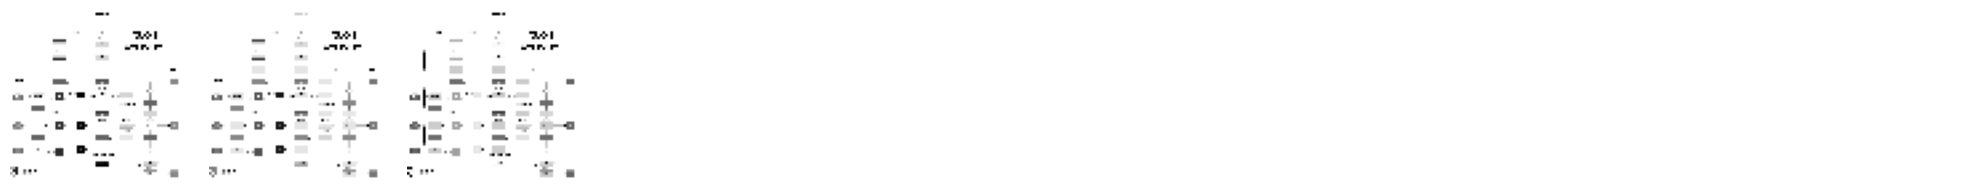

In [48]:
class Silence(nn.Module):
    def __init__(self):
        super(Silence, self).__init__()
    def forward(self, x):
        return x

silence = Silence()
data = silence(data)
print(data.shape) # [1, 3, 8, 8]
# print(data)
show_images(data)

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### <font color = aqua>Conv [64, 3, 2]    

In [50]:
def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p
class Conv(nn.Module):  # Standard convolution with args(channel_in, channel_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))

    #-----------Extra------------
    def __call__(self, x):
        return self.forward(x)

conv = Conv(c1=channels, c2=64, k=3, s=2)
data = conv(data)
print(data.shape)
# print(data)

batch_size = data.shape[0]
channels = data.shape[1]
height = data.shape[2]
width = data.shape[3]

torch.Size([1, 64, 32, 32])


In [51]:
conv = Conv(channels,128,3,2)
data = conv(data)
print(data.shape)
channels = data.shape[1]

torch.Size([1, 128, 16, 16])


In [52]:
model = RepNCSPELAN4(channels,256,128,64,1)
data = model(data)
print(data.shape)
channels = data.shape[1]

torch.Size([1, 256, 16, 16])


In [53]:
model = ADown(channels,256)
data = model(data)
print(data.shape)
channels = data.shape[1]

torch.Size([1, 256, 8, 8])


In [54]:
model = RepNCSPELAN4(channels,512,256,128,1)
data = model(data)
print(data.shape)
channels = data.shape[1]

torch.Size([1, 512, 8, 8])


In [55]:
model = ADown(channels,512)
data = model(data)
print(data.shape)
channels = data.shape[1]

torch.Size([1, 512, 4, 4])


In [56]:
model = RepNCSPELAN4(channels,512,512,256,1)
data = model(data)
print(data.shape)
channels = data.shape[1]

torch.Size([1, 512, 4, 4])


In [57]:
model = ADown(channels,512)
data = model(data)
print(data.shape)
channels = data.shape[1]

torch.Size([1, 512, 2, 2])


In [58]:
model = RepNCSPELAN4(channels,512,512,256,1)
data = model(data)
print(data.shape)
channels = data.shape[1]

torch.Size([1, 512, 2, 2])


In [59]:
model = SPPELAN(channels,512,256)
data = model(data)
print(data.shape)
channels = data.shape[1]

torch.Size([1, 512, 2, 2])


In [60]:
model = nn.Upsample(scale_factor=2, mode='nearest')
data = model(data)
print(data.shape)
channels = data.shape[1]

torch.Size([1, 512, 4, 4])
